## VISA APPROVAL PREDICTION

In [113]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    classification_report,
    make_scorer,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To filter the warnings
import warnings
warnings.filterwarnings("ignore")

# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn import metrics

# Library for scaling
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

from sklearn import tree
from sklearn.model_selection import GridSearchCV

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model building libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [114]:
d = pd.read_csv(r"C:\Users\LOKI\Downloads\EasyVisa.csv")

In [115]:
d.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [116]:
print(f"Shape: There are {d.shape[0]} rows and {d.shape[1]} columns")

Shape: There are 25480 rows and 12 columns


In [117]:
print(f"There are {d.duplicated().sum()} duplicates in this dataset.")

There are 0 duplicates in this dataset.


In [118]:
d.drop("case_id",axis = 1,inplace = True)

In [119]:
for i in d.columns:
    print(f"{i} : {d[i].nunique()}")

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
no_of_employees : 7105
yr_of_estab : 199
region_of_employment : 5
prevailing_wage : 25454
unit_of_wage : 4
full_time_position : 2
case_status : 2


In [120]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              25480 non-null  object 
 1   education_of_employee  25480 non-null  object 
 2   has_job_experience     25480 non-null  object 
 3   requires_job_training  25480 non-null  object 
 4   no_of_employees        25480 non-null  int64  
 5   yr_of_estab            25480 non-null  int64  
 6   region_of_employment   25480 non-null  object 
 7   prevailing_wage        25480 non-null  float64
 8   unit_of_wage           25480 non-null  object 
 9   full_time_position     25480 non-null  object 
 10  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 2.1+ MB


In [121]:
d.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000


In [122]:
d.isnull().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [123]:
c = d.select_dtypes(include=object).columns.tolist()
for i in c:
    print(d[i].value_counts())
    print("---------------------------------")

continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
---------------------------------
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
---------------------------------
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
---------------------------------
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64
---------------------------------
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64
---------------------------------
unit_of_wage
Year     22962
Hour      2157
Week       272
Month       89
Name: count, dtype: int64
---------------------------------
full_time_position
Y    22773
N     2707
Name: count, dtype: int64
---------------------------------
case_status
Cert

## Exploratory Data Analysis (EDA)

### Univariate Analysis

In [124]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [125]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [126]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [127]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

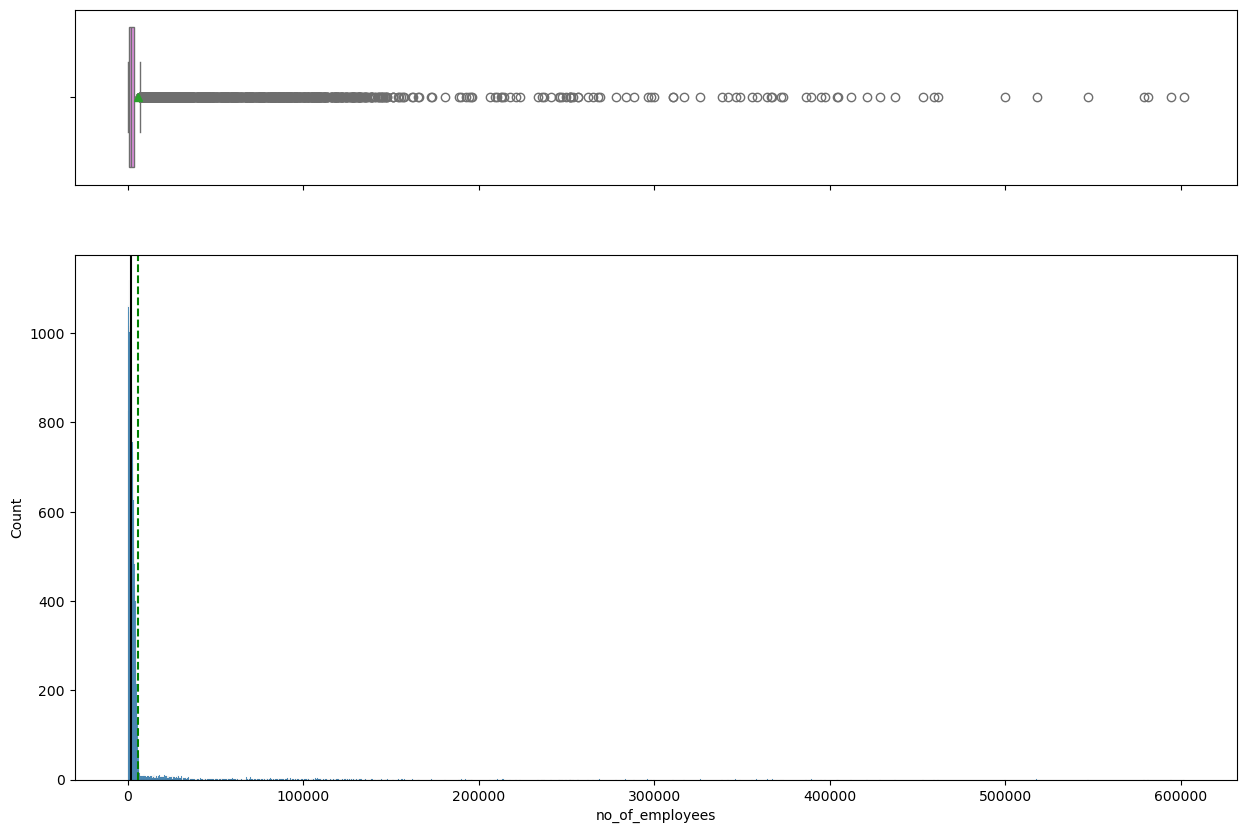

In [128]:
histogram_boxplot(d, "no_of_employees")

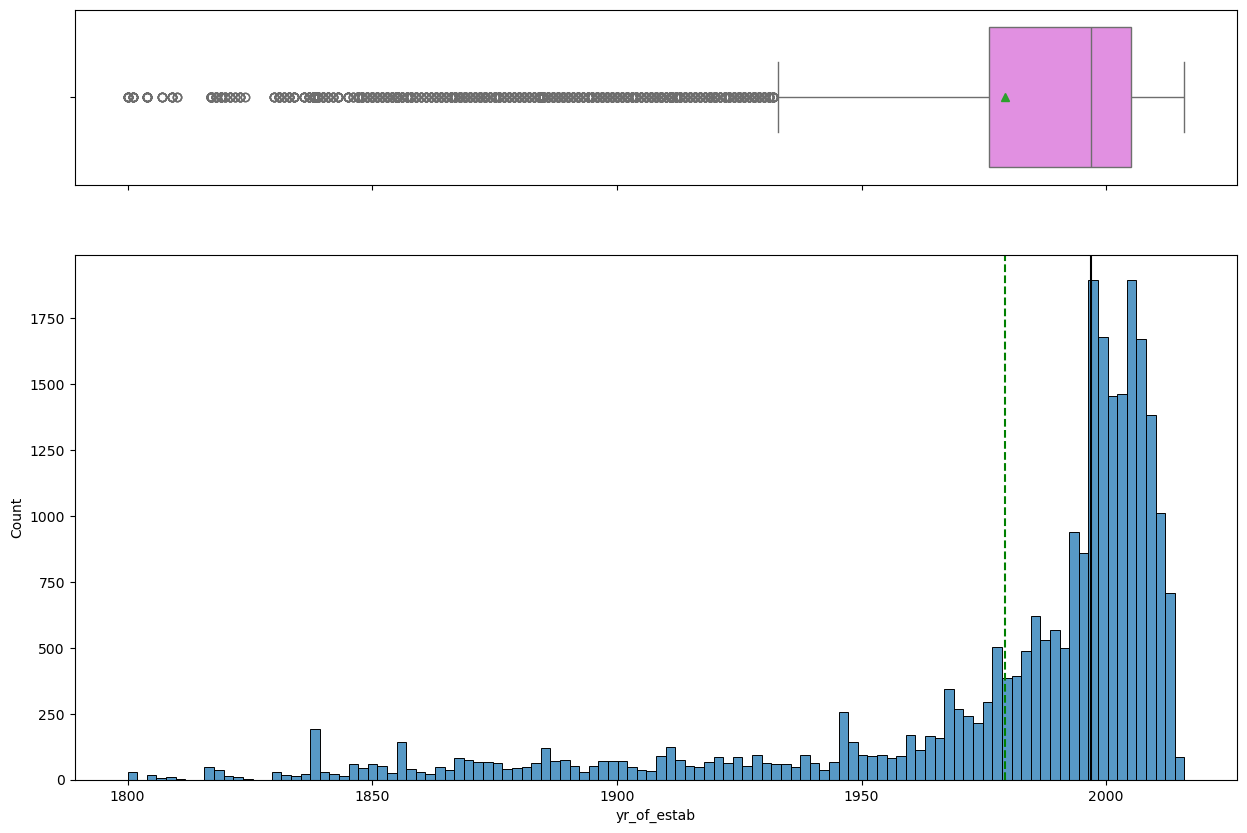

In [129]:
histogram_boxplot(d, "yr_of_estab")

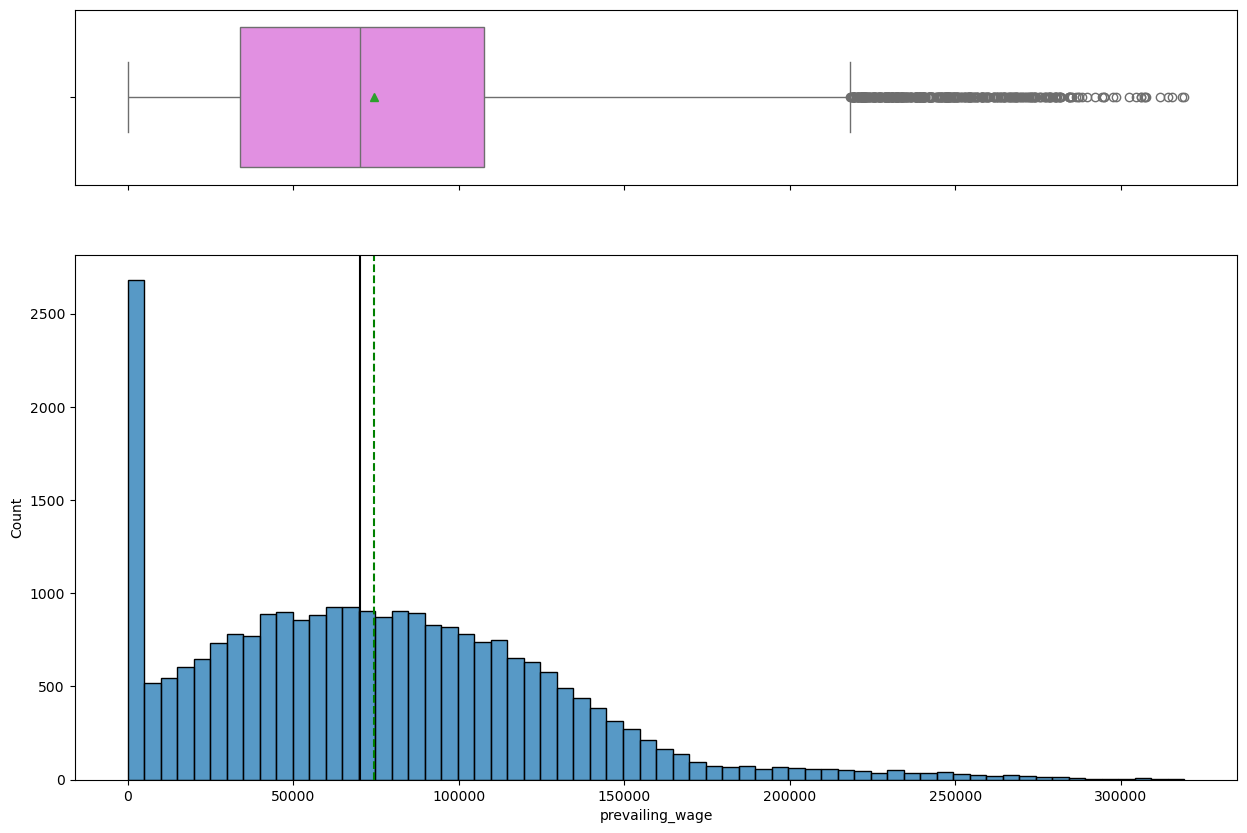

In [130]:
histogram_boxplot(d, "prevailing_wage")

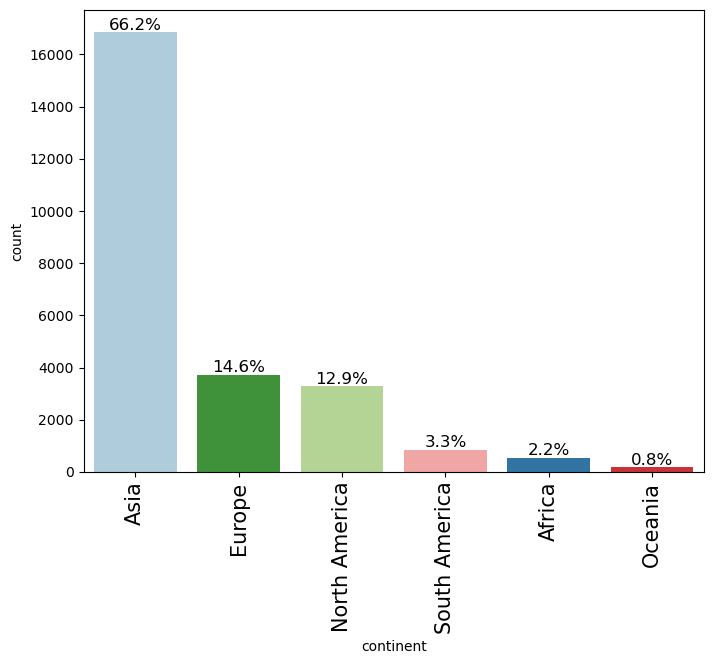

In [131]:
labeled_barplot(d,"continent",perc=True);

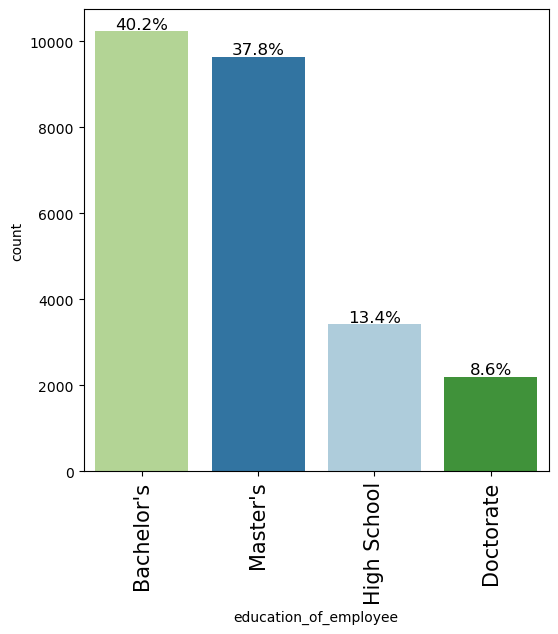

In [132]:
labeled_barplot(d,"education_of_employee",perc=True);

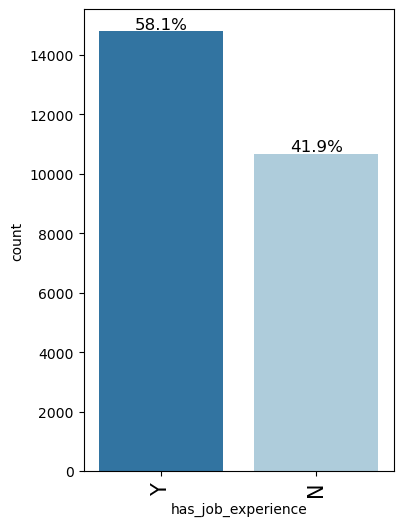

In [133]:
labeled_barplot(d,"has_job_experience",perc=True);

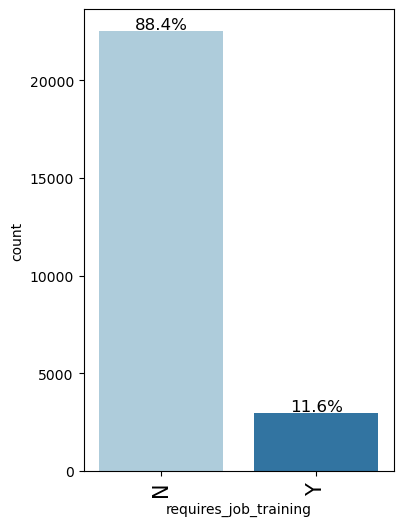

In [134]:
labeled_barplot(d,"requires_job_training",perc=True);

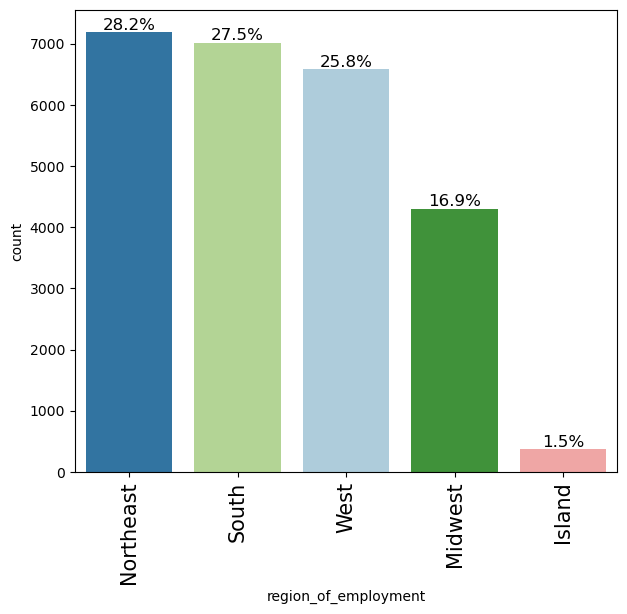

In [135]:
labeled_barplot(d,"region_of_employment",perc=True);

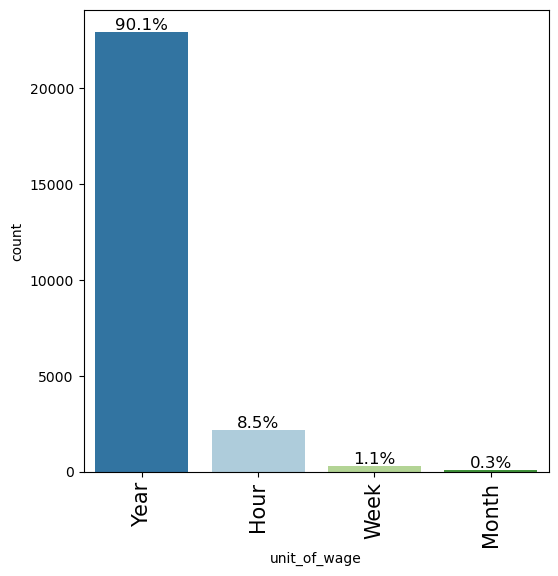

In [136]:
labeled_barplot(d,"unit_of_wage",perc=True);

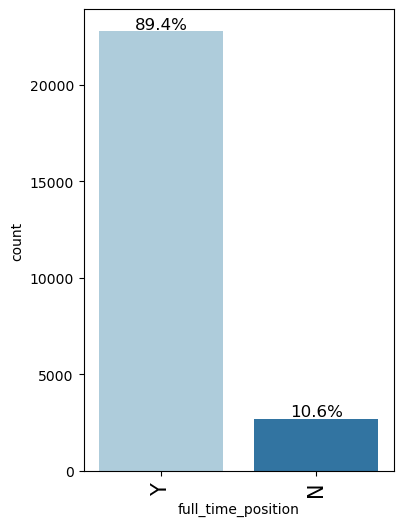

In [137]:
labeled_barplot(d,"full_time_position",perc=True);

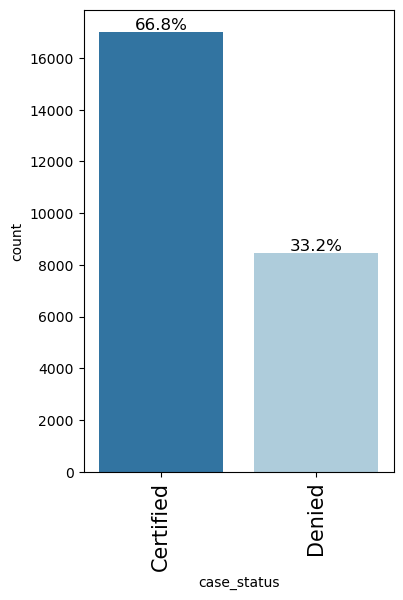

In [138]:
labeled_barplot(d,"case_status",perc=True);

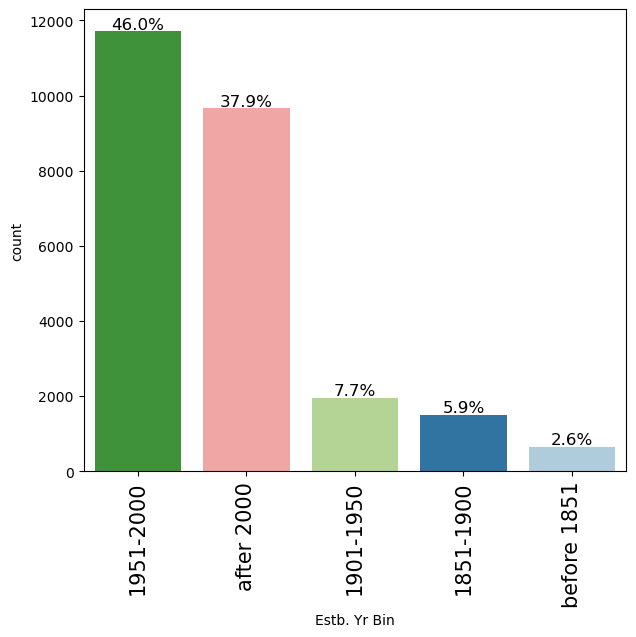

In [139]:
df1 = pd.DataFrame()
bins = [-np.inf, 1850, 1900, 1950, 2000, np.inf]
names = ['before 1851', '1851-1900','1901-1950', '1951-2000','after 2000']

df1['Estb. Yr Bin'] = pd.cut(d['yr_of_estab'], bins, labels=names)

labeled_barplot(df1,"Estb. Yr Bin",perc=True);

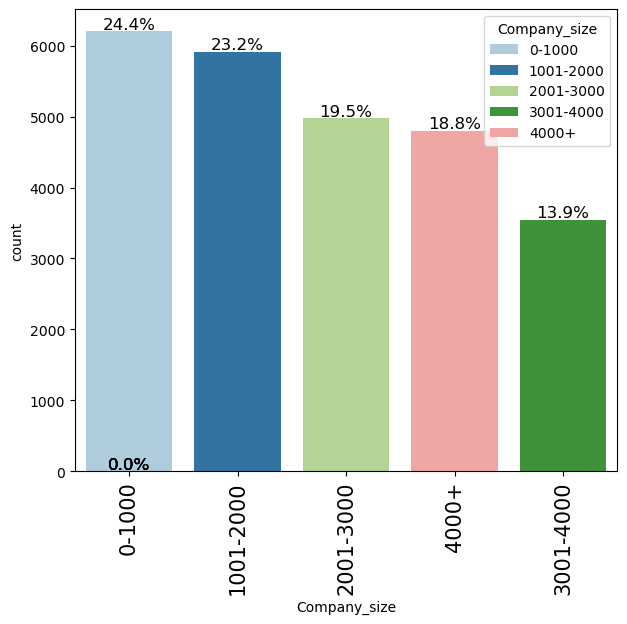

In [140]:
df2 = pd.DataFrame()
bins = [0, 1000, 2000, 3000, 4000, np.Inf]
names = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4000+']

df2['Company_size'] = pd.cut(d['no_of_employees'], bins, labels=names)
labeled_barplot(df2,"Company_size",perc=True);

### Bivariate Analysis

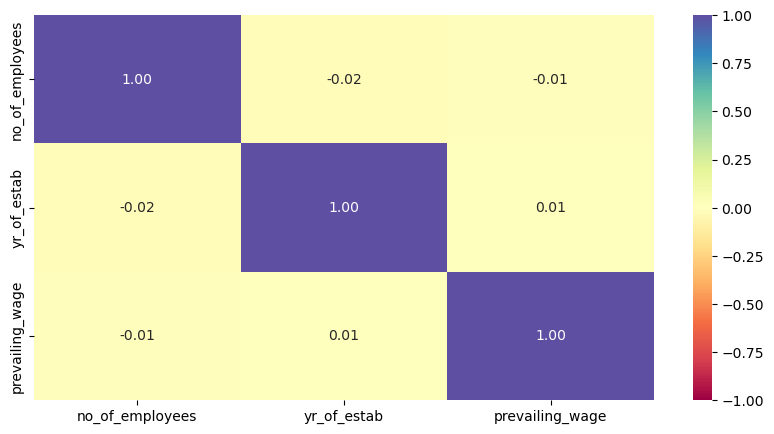

In [141]:
cols_list = d.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 5))
sns.heatmap(
    d[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

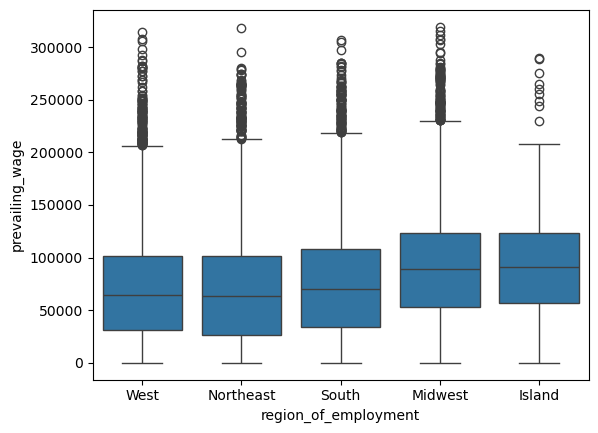

In [142]:
sns.boxplot(d, x="region_of_employment", y="prevailing_wage");

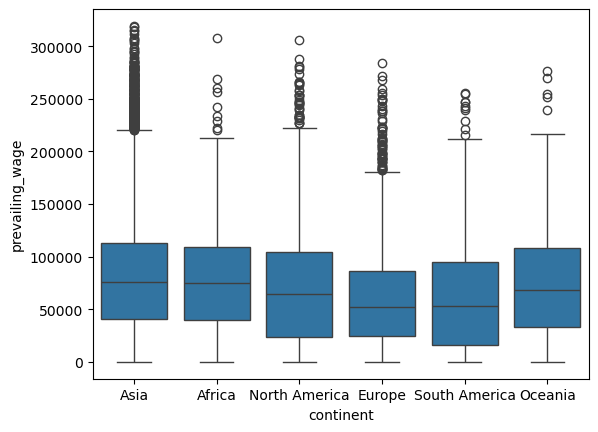

In [143]:
sns.boxplot(d, x="continent", y="prevailing_wage");

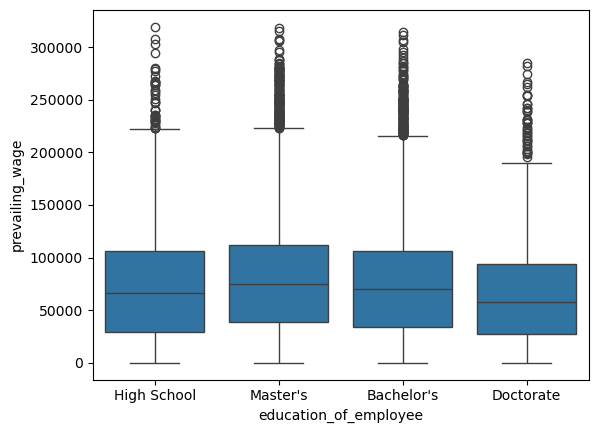

In [144]:
sns.boxplot(d, x="education_of_employee", y="prevailing_wage");

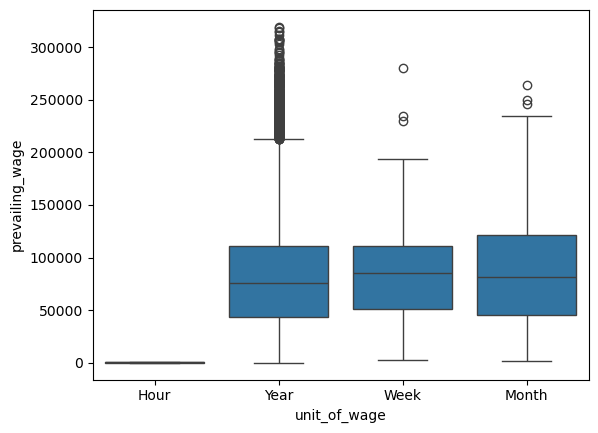

In [145]:
sns.boxplot(d, x="unit_of_wage", y="prevailing_wage");

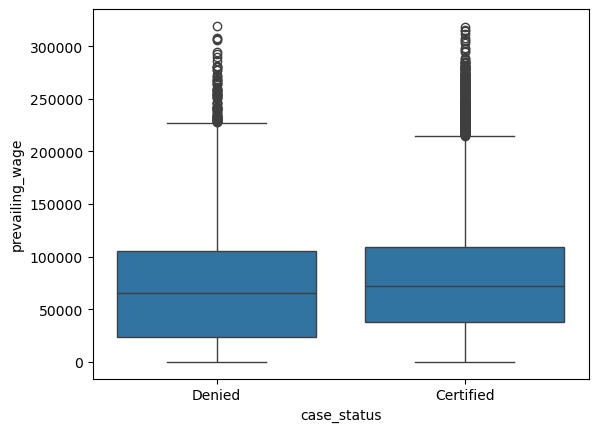

In [146]:
sns.boxplot(d, x="case_status", y="prevailing_wage");

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


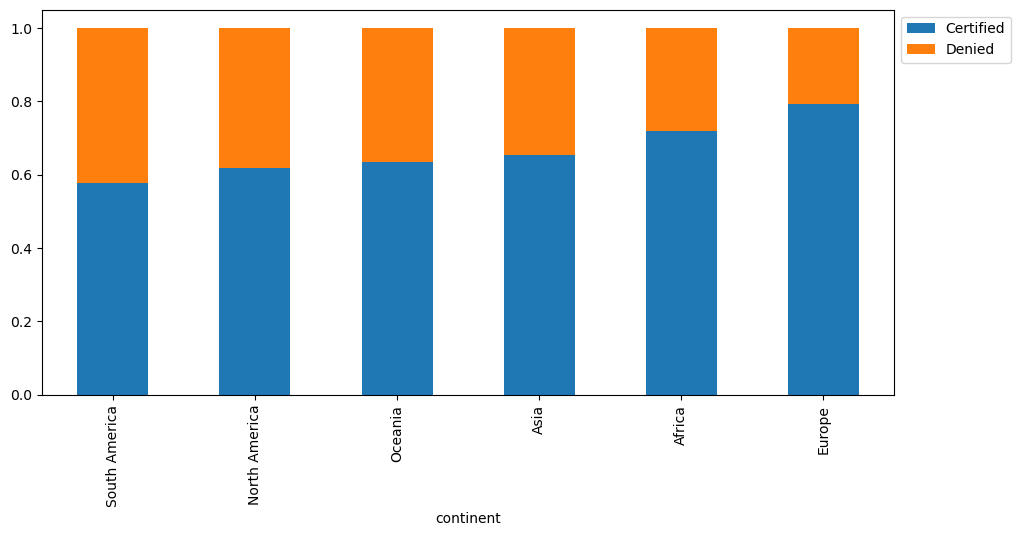

In [147]:
stacked_barplot(d,'continent','case_status')

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


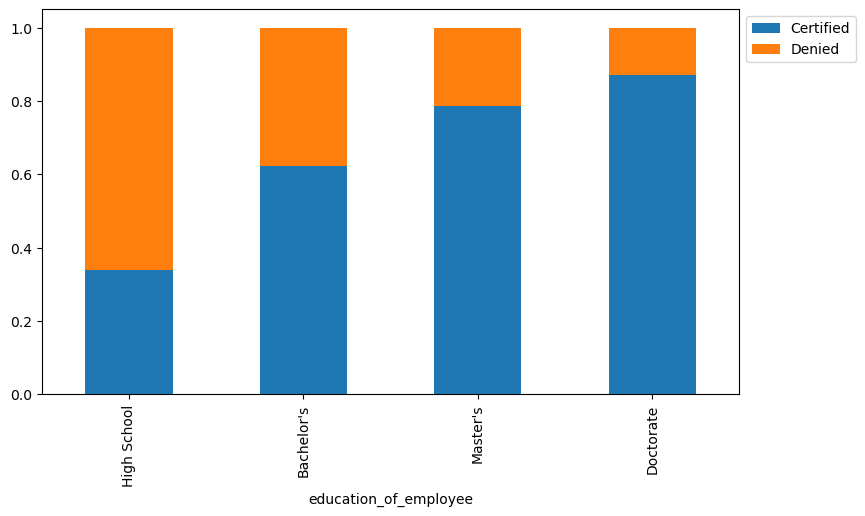

In [148]:
stacked_barplot(d,'education_of_employee','case_status')

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


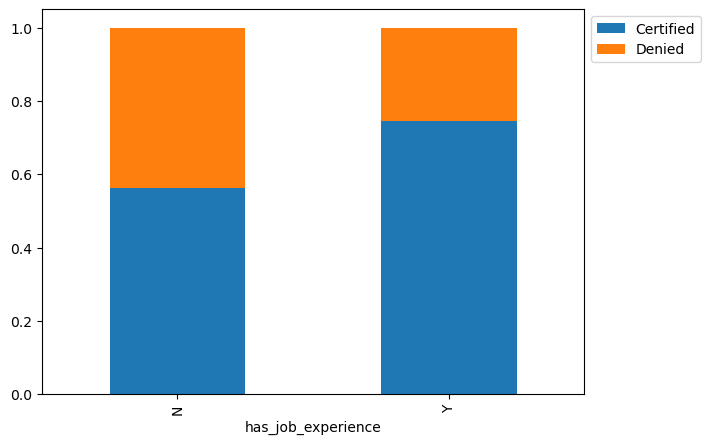

In [149]:
stacked_barplot(d,'has_job_experience','case_status')

case_status            Certified  Denied    All
requires_job_training                          
All                        17018    8462  25480
N                          15012    7513  22525
Y                           2006     949   2955
------------------------------------------------------------------------------------------------------------------------


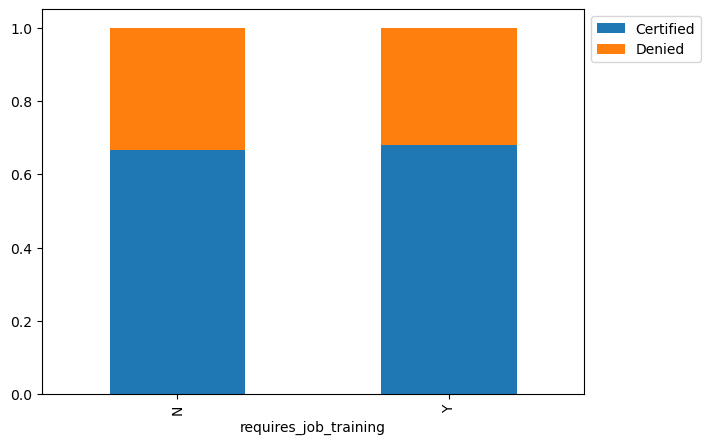

In [150]:
stacked_barplot(d,'requires_job_training','case_status')

case_status           Certified  Denied    All
region_of_employment                          
All                       17018    8462  25480
Northeast                  4526    2669   7195
West                       4100    2486   6586
South                      4913    2104   7017
Midwest                    3253    1054   4307
Island                      226     149    375
------------------------------------------------------------------------------------------------------------------------


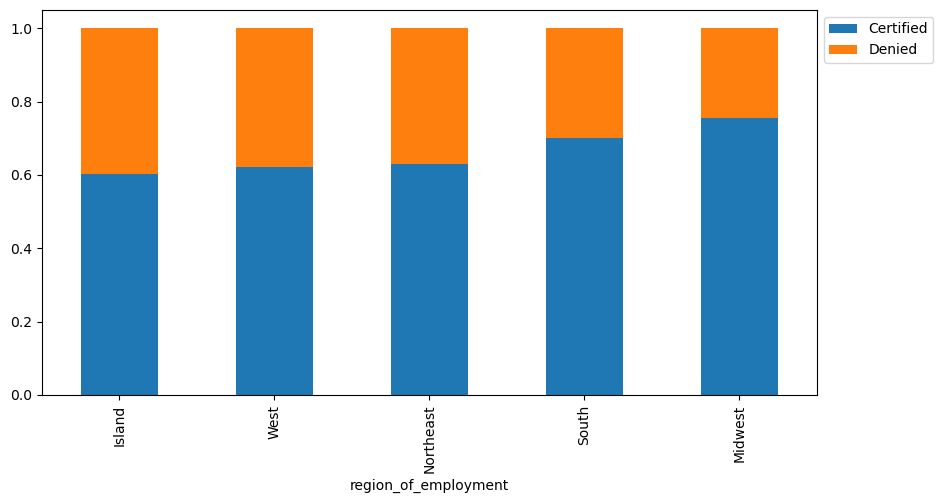

In [151]:
stacked_barplot(d,'region_of_employment','case_status')

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


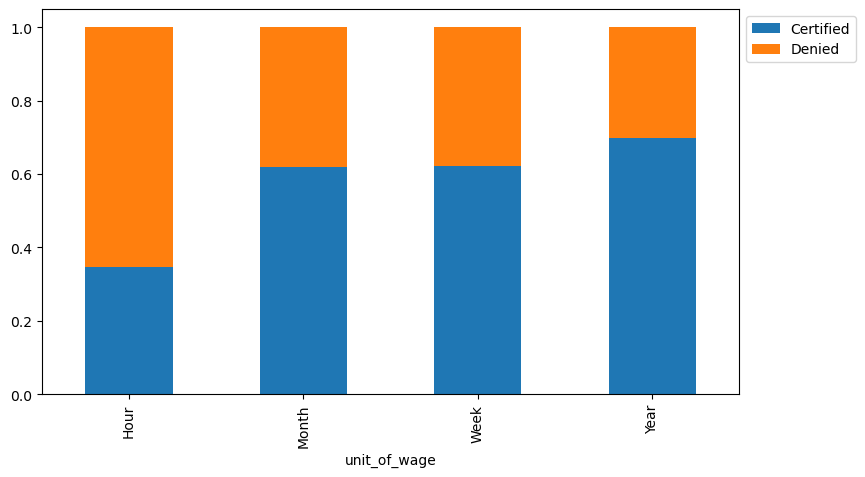

In [152]:
stacked_barplot(d,'unit_of_wage','case_status')

case_status         Certified  Denied    All
full_time_position                          
All                     17018    8462  25480
Y                       15163    7610  22773
N                        1855     852   2707
------------------------------------------------------------------------------------------------------------------------


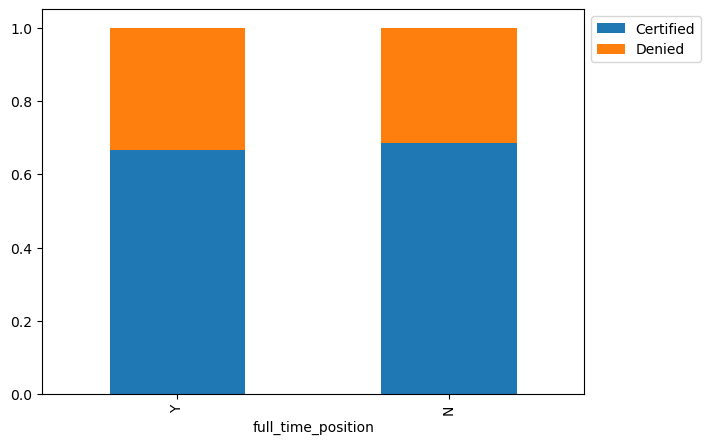

In [153]:
stacked_barplot(d,'full_time_position','case_status')

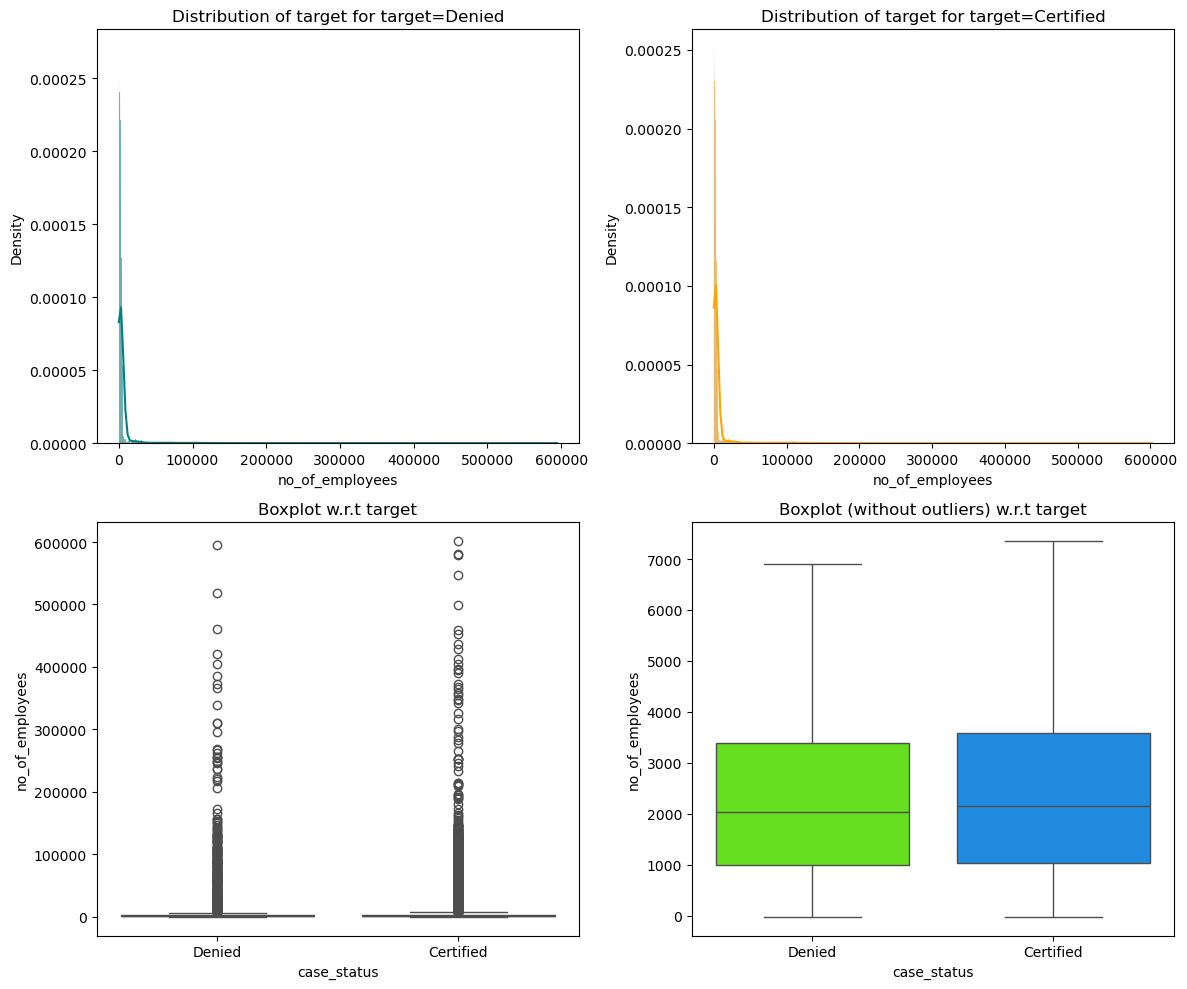

In [154]:
distribution_plot_wrt_target(d, 'no_of_employees', 'case_status')

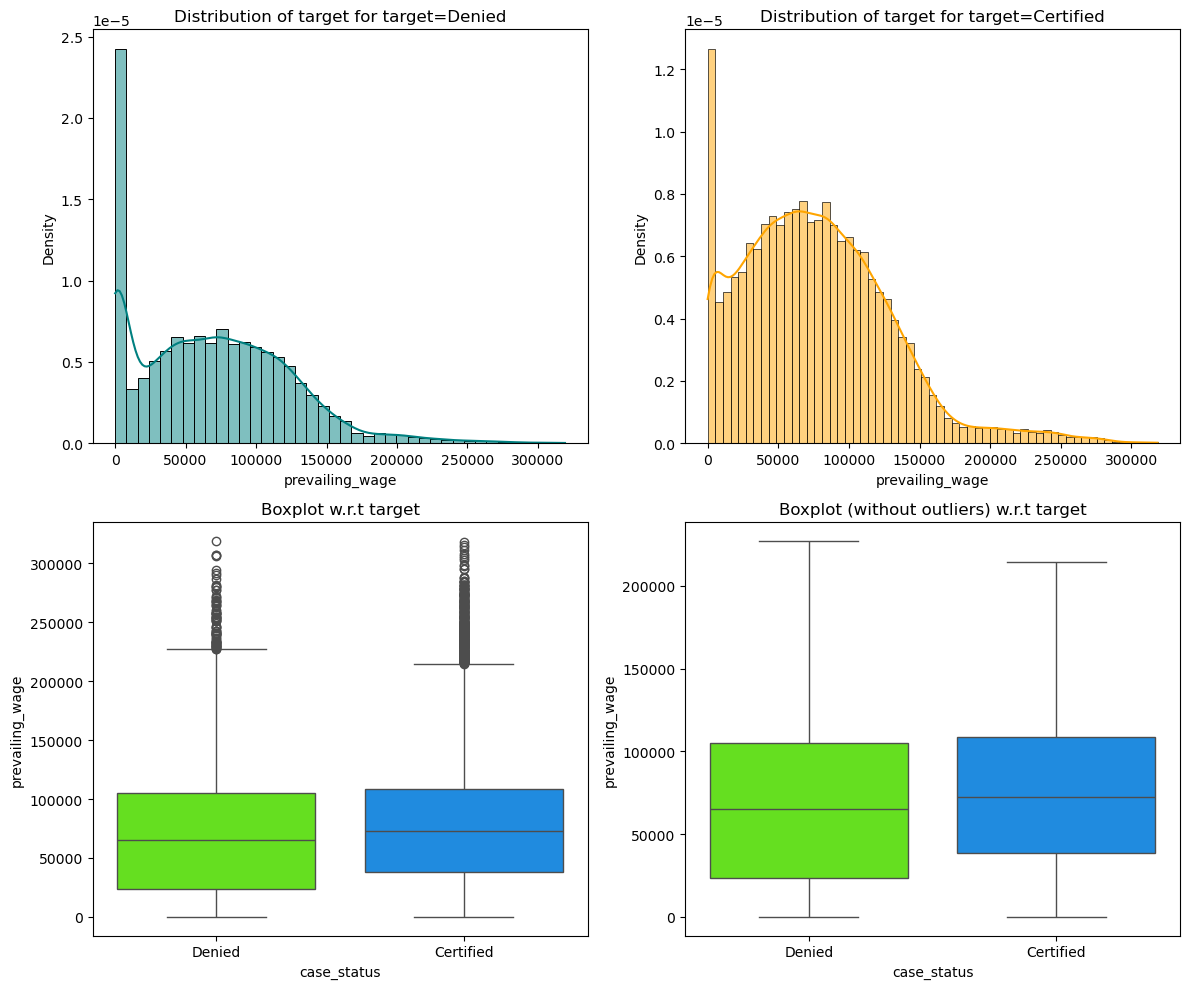

In [155]:
distribution_plot_wrt_target(d, 'prevailing_wage', 'case_status')

## DATA PREPROCESSING 

### Missing value treatment

In [156]:
d.isnull().sum()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

### Outlier treatment

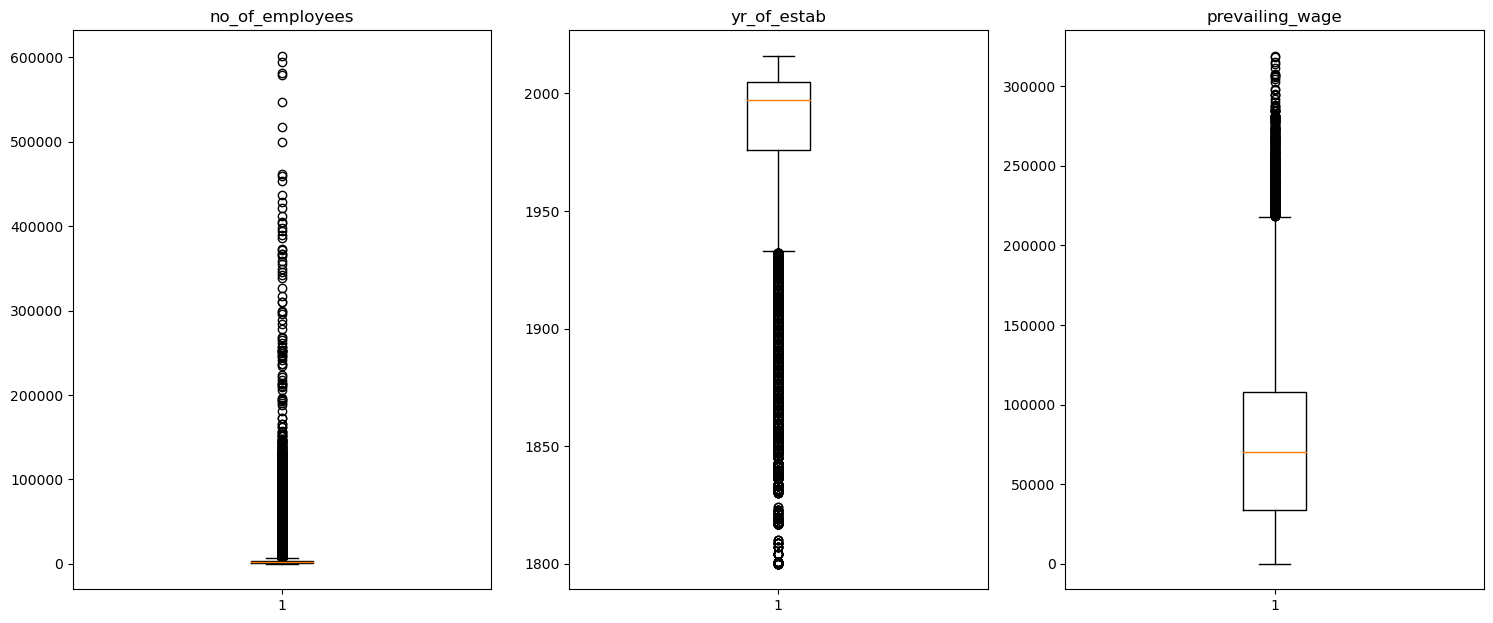

In [157]:
# outlier detection using boxplot
num_cols = d.select_dtypes(include=np.number).columns.tolist()

# let's look at box plot to see if outliers have been treated or not
plt.figure(figsize=(20, 30))

for i, variable in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(d[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Feature Engineering

### 1. Dealing negative entries of No_of_employees column

In [158]:
len(d.loc[d["no_of_employees"]<=0])

33

There are 33 rows which has negative entries of no_of_employees and are dropped.

In [159]:
d = d[d.no_of_employees>0]

### 2. Categorizing the ''yr_of_estab'' column

In [160]:
bins = [-np.inf, 1850, 1900, 1950, 2000, np.inf]
names = ['before 1851', '1851-1900','1901-1950', '1951-2000','after 2000']

d['Estb. Yr Bin'] = pd.cut(d['yr_of_estab'], bins, labels=names)

### 3. Categorizing the ''no_of_employees" column

In [161]:
bins = [0, 1000, 2000, 3000, 4000, np.Inf]
names = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4000+']

d['Company_size'] = pd.cut(d['no_of_employees'], bins, labels=names)

### 4. Labelling the Target variable

In [162]:
d["case_status"] = d["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

In [163]:
d["case_status"].value_counts()

case_status
1    17001
0     8446
Name: count, dtype: int64

### Splitting dataset for model

In [164]:
X = d.drop(["case_status","no_of_employees","yr_of_estab"], axis=1)
y = d["case_status"]

dum_cols = ['continent', 'education_of_employee', 'has_job_experience',
            'requires_job_training','region_of_employment', 'unit_of_wage',
            'full_time_position', 'Estb. Yr Bin', 'Company_size']

X = pd.get_dummies(X,columns = dum_cols,drop_first=True)

X = X.astype(float)

# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(15267, 27) (5090, 27) (5090, 27)


In [165]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 15267
Number of rows in validation data = 5090
Number of rows in test data = 5090


## Initial Model Building

In [166]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [167]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Model Building - Original Data

In [168]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGB", XGBClassifier(random_state=1,eval_metric='logloss',enable_categorical=True)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.9804882831650161
Random forest: 1.0
GBM: 0.8721443278752818
Adaboost: 0.8857731150112756
XGB: 0.9210706932052162

Validation Performance:

Bagging: 0.7741840635107321
Random forest: 0.7862393413701853
GBM: 0.8762128785651279
Adaboost: 0.8912084680976183
XGB: 0.8579829461922964


In [169]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_train = recall_score(y_train, model.predict(X_train))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference1 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference1))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9805, Validation Score: 0.7742, Difference: 0.2063
Random forest: Training Score: 1.0000, Validation Score: 0.7862, Difference: 0.2138
GBM: Training Score: 0.8721, Validation Score: 0.8762, Difference: -0.0041
Adaboost: Training Score: 0.8858, Validation Score: 0.8912, Difference: -0.0054
XGB: Training Score: 0.9211, Validation Score: 0.8580, Difference: 0.0631


### Model Building - Oversampled Data

In [170]:
print("Before Oversampling, counts of label 'Cerified': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'Denied': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Cerified': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'Denied': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Cerified': 10199
Before Oversampling, counts of label 'Denied': 5068 

After Oversampling, counts of label 'Cerified': 10199
After Oversampling, counts of label 'Denied': 10199 

After Oversampling, the shape of train_X: (20398, 27)
After Oversampling, the shape of train_y: (20398,) 



In [171]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGB", XGBClassifier(random_state=1,eval_metric='logloss',enable_categorical=True)))

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9804882831650161
Random forest: 0.9999019511716835
GBM: 0.8680262770859888
Adaboost: 0.8517501715854495
XGB: 0.9123443474850476

Validation Performance:

Bagging: 0.7650690973243164
Random forest: 0.7827109673625404
GBM: 0.8709203175536607
Adaboost: 0.8576889150249927
XGB: 0.8571008526903852


In [172]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_train = recall_score(y_train_over, model.predict(X_train_over))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference2 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9805, Validation Score: 0.7651, Difference: 0.2154
Random forest: Training Score: 0.9999, Validation Score: 0.7827, Difference: 0.2172
GBM: Training Score: 0.8680, Validation Score: 0.8709, Difference: -0.0029
Adaboost: Training Score: 0.8518, Validation Score: 0.8577, Difference: -0.0059
XGB: Training Score: 0.9123, Validation Score: 0.8571, Difference: 0.0552


### Model Building - Undersampled Data

In [173]:
print("Before Under Sampling, counts of label 'Cerified': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'Denied': {} \n".format(sum(y_train == 0)))

rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print("After Under Sampling, counts of label 'Cerified': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'Denied': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Cerified': 10199
Before Under Sampling, counts of label 'Denied': 5068 

After Under Sampling, counts of label 'Cerified': 5068
After Under Sampling, counts of label 'Denied': 5068 

After Under Sampling, the shape of train_X: (10136, 27)
After Under Sampling, the shape of train_y: (10136,) 



In [174]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGB", XGBClassifier(random_state=1,eval_metric='logloss',enable_categorical=True)))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9636937647987371
Random forest: 0.999802683504341
GBM: 0.7407261247040252
Adaboost: 0.7063930544593529
XGB: 0.8196527229676401

Validation Performance:

Bagging: 0.6177594825051456
Random forest: 0.6489267862393414
GBM: 0.7236107027344899
Adaboost: 0.7162599235518965
XGB: 0.69920611584828


In [175]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_train = recall_score(y_train_un, model.predict(X_train_un))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference3 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference3))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9637, Validation Score: 0.6178, Difference: 0.3459
Random forest: Training Score: 0.9998, Validation Score: 0.6489, Difference: 0.3509
GBM: Training Score: 0.7407, Validation Score: 0.7236, Difference: 0.0171
Adaboost: Training Score: 0.7064, Validation Score: 0.7163, Difference: -0.0099
XGB: Training Score: 0.8197, Validation Score: 0.6992, Difference: 0.1204


## HYPER-PARAMETER TUNING

### 1. Tuning Ada-Boost model with original data

In [176]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 30, 'learning_rate': 0.05, 'estimator': DecisionTreeClassifier(max_depth=1, random_state=1)} with CV score=0.9721542182346209:
CPU times: total: 3.86 s
Wall time: 21.4 s


In [177]:
tuned_adb_og = AdaBoostClassifier(
    random_state=1,
    n_estimators=30,
    learning_rate=0.05,
    estimator=DecisionTreeClassifier(max_depth=1, random_state=1))
tuned_adb_og.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=1),
                   learning_rate=0.05, n_estimators=30, random_state=1)

In [178]:
# Checking model's performance on training set
print("Training set Performance")
adb_train_og = model_performance_classification_sklearn(tuned_adb_og, X_train, y_train)
adb_train_og

Training set Performance


,Accuracy,Recall,Precision,F1
0,0.690312,0.972448,0.690428,0.807523


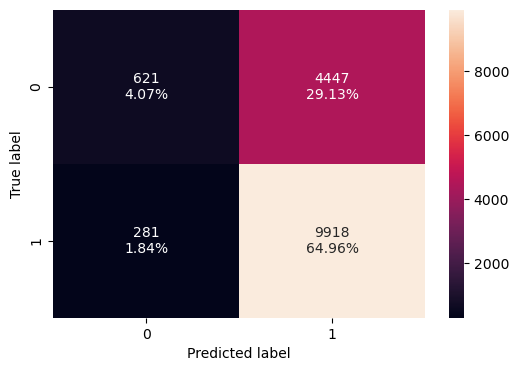

In [179]:
confusion_matrix_sklearn(tuned_adb_og, X_train, y_train)

In [180]:
# Checking model's performance on validation set
print("Validation set Performance")
adb_val_og = model_performance_classification_sklearn(tuned_adb_og, X_val, y_val)
adb_val_og

Validation set Performance


,Accuracy,Recall,Precision,F1
0,0.693713,0.971479,0.693244,0.80911


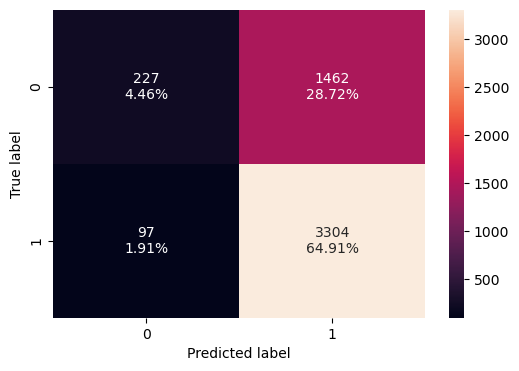

In [181]:
confusion_matrix_sklearn(tuned_adb_og, X_val, y_val)

### 2. Tuning Gradient Boosting model with original data

In [182]:
%%time

#defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 1, 'learning_rate': 0.01, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.9947055457788805:
CPU times: total: 3.17 s
Wall time: 23.6 s


In [183]:
tuned_gbm_og = GradientBoostingClassifier(
    random_state=1,
    subsample=0.5,
    n_estimators=125,
    max_features=1,
    learning_rate=0.01,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm_og.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.01, max_features=1, n_estimators=125,
                           random_state=1, subsample=0.5)

In [184]:
# Checking model's performance on training set
print("Training set Performance")
gbm_og_train = model_performance_classification_sklearn(tuned_gbm_og, X_train, y_train)
gbm_og_train

Training set Performance


,Accuracy,Recall,Precision,F1
0,0.68088,0.992254,0.678603,0.805989


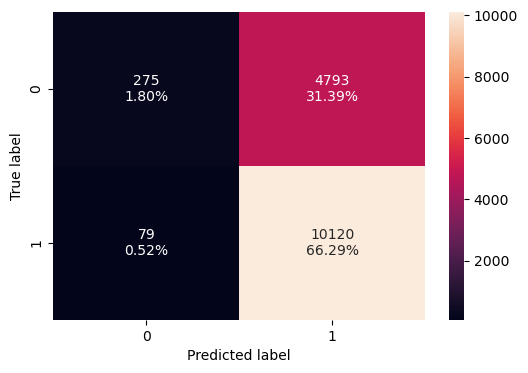

In [185]:
confusion_matrix_sklearn(tuned_gbm_og, X_train, y_train)

In [186]:
# Checking model's performance on validation set
print("Validation set Performance")
gbm_og_val = model_performance_classification_sklearn(tuned_gbm_og, X_val, y_val)
gbm_og_val

Validation set Performance


,Accuracy,Recall,Precision,F1
0,0.682515,0.992061,0.679831,0.806791


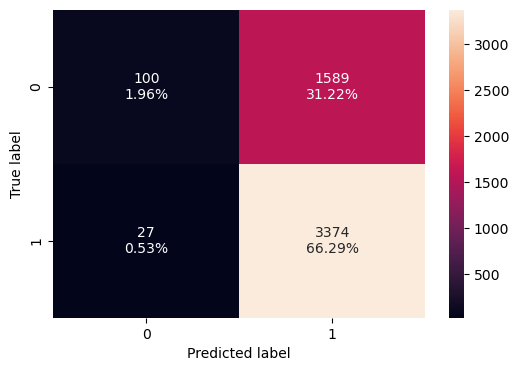

In [187]:
confusion_matrix_sklearn(tuned_gbm_og, X_val, y_val)

### 3. Tuning AdaBoost model with oversampled data

In [188]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 10, 'learning_rate': 0.01, 'estimator': DecisionTreeClassifier(max_depth=1, random_state=1)} with CV score=0.9314642414101492:
CPU times: total: 3.44 s
Wall time: 11.9 s


In [189]:
tuned_adb_over = AdaBoostClassifier(
    random_state=1,
    n_estimators=10,
    learning_rate=0.01,
    estimator=DecisionTreeClassifier(max_depth=1, random_state=1))
tuned_adb_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=1),
                   learning_rate=0.01, n_estimators=10, random_state=1)

In [190]:
# Checking model's performance on training set
print("Training set Performance")
adb_train_over = model_performance_classification_sklearn(tuned_adb_over, X_train_over, y_train_over)
adb_train_over

Training set Performance


,Accuracy,Recall,Precision,F1
0,0.648789,0.931464,0.595052,0.726189


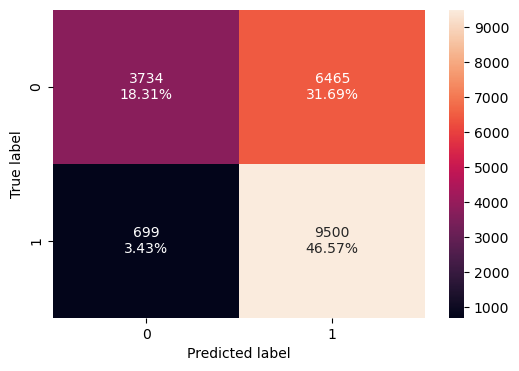

In [191]:
confusion_matrix_sklearn(tuned_adb_over, X_train_over, y_train_over)

In [192]:
# Checking model's performance on validation set
print("Validation set Performance")
adb_val_over = model_performance_classification_sklearn(tuned_adb_over, X_val, y_val)
adb_val_over

Validation set Performance


,Accuracy,Recall,Precision,F1
0,0.709627,0.932961,0.717386,0.811094


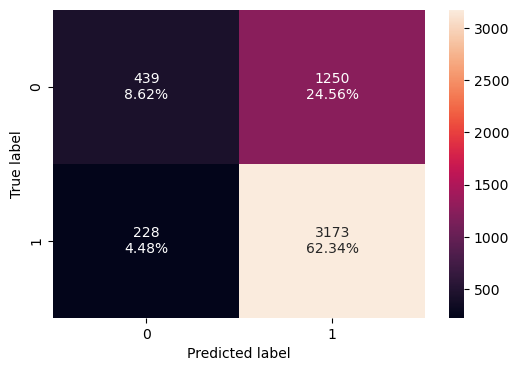

In [193]:
confusion_matrix_sklearn(tuned_adb_over, X_val, y_val)

## Model Comparison and Final Model Selection

In [194]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        adb_train_og.T,
        gbm_og_train.T,
        adb_train_over.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost trained with Original data",
    "Gradient boosting trained with Original data",
    "AdaBoost trained with Oversampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost trained with Original data,Gradient boosting trained with Original data,AdaBoost trained with Oversampled data
Accuracy,0.690312,0.680880,0.648789
Recall,0.972448,0.992254,0.931464
Precision,0.690428,0.678603,0.595052
F1,0.807523,0.805989,0.726189


In [195]:
# Validation performance comparison

models_train_comp_df = pd.concat(
    [ adb_val_og.T, gbm_og_val.T, adb_val_over.T], axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost trained with Original data",
    "Gradient boosting trained with Original data",
    "AdaBoost trained with Oversampled data",
]
print("Validation performance comparison:")
models_train_comp_df

Validation performance comparison:


,AdaBoost trained with Original data,Gradient boosting trained with Original data,AdaBoost trained with Oversampled data
Accuracy,0.693713,0.682515,0.709627
Recall,0.971479,0.992061,0.932961
Precision,0.693244,0.679831,0.717386
F1,0.809110,0.806791,0.811094


## Model Performance on test set

In [196]:
# Let's check the performance on test set
print("Test set Performance")
best_model = model_performance_classification_sklearn(tuned_gbm_og, X_test, y_test)
best_model

Test set Performance


,Accuracy,Recall,Precision,F1
0,0.682711,0.992649,0.679823,0.80698


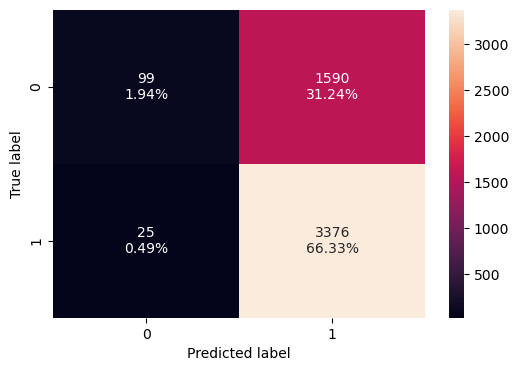

In [197]:
confusion_matrix_sklearn(tuned_gbm_og, X_test, y_test)

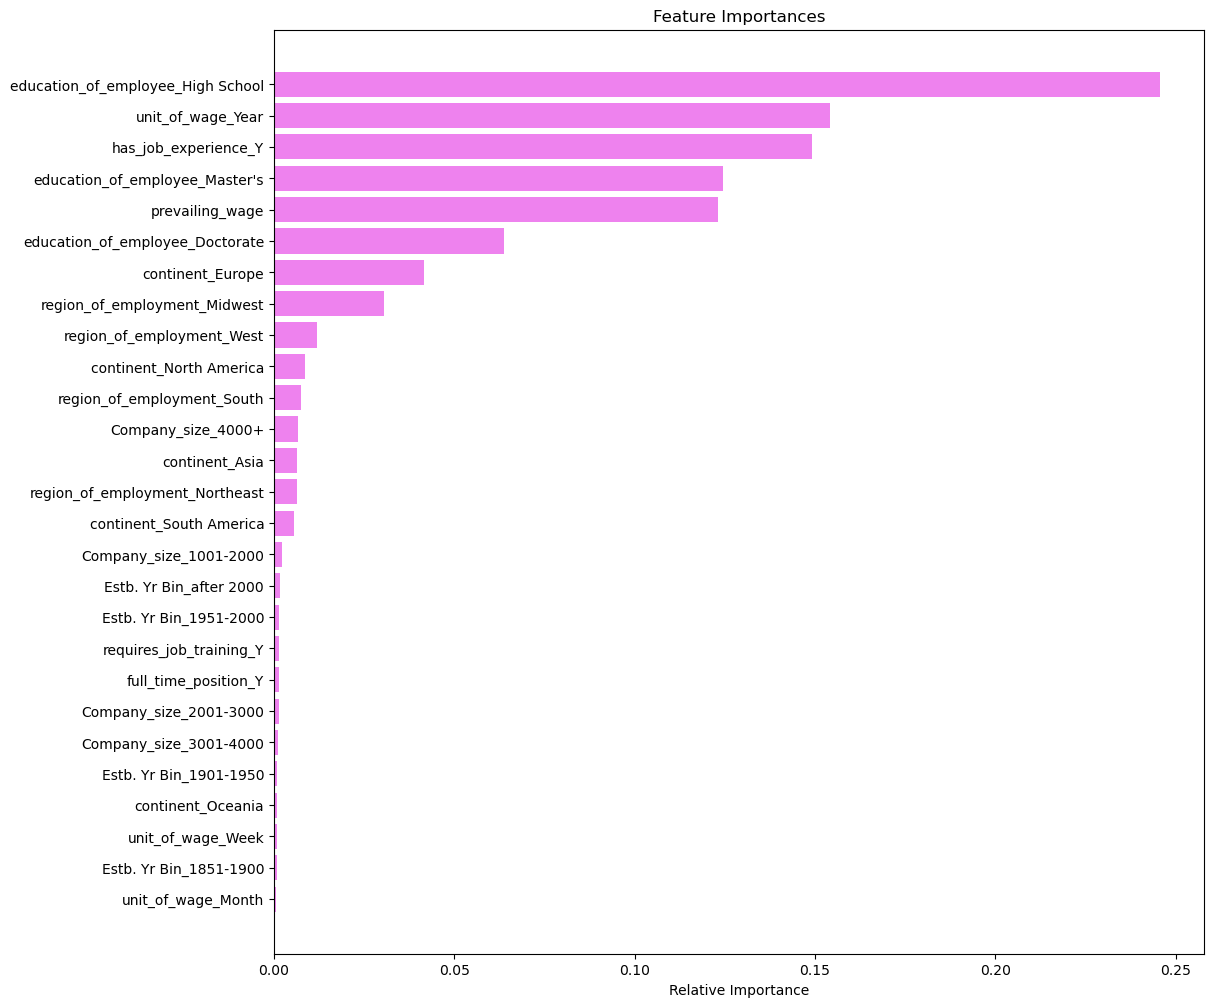

In [198]:
feature_names = X_train.columns
importances = tuned_gbm_og.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()